In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import theano
import exoplanet as xo
import pymc3 as pm
import theano.tensor as tt
from scipy.signal import savgol_filter
import math
from scipy import special
import pymc3_ext as pmx

from functools import partial

In [2]:
def multiflaremodel(t, tpeaks, fwhms, ampls):
    t = t.astype('float64')
    t = tt.as_tensor_variable(t)
    multiflare_lc = tt.zeros_like(t)
    flare_lc = tt.zeros_like(t)
    
    def scan_func(tpeak, fwhm, ampl):
        zeropad_flare_lc = tt.zeros_like(t)
        tcut = (((t - tpeak)/fwhm > -1.) * ((t - tpeak)/fwhm < 100.)).nonzero()
        flare_lc = _flaremodel_tovar(t[tcut], tpeak, fwhm, ampl)
        zeropad_flare_lc = tt.set_subtensor(zeropad_flare_lc[tcut],  flare_lc)
        return zeropad_flare_lc
    
    components, updates = theano.scan(fn=scan_func,
                                      sequences=[tpeaks, fwhms, ampls],
                                      )
    multiflare_lc = tt.sum(components, axis=0)
    
    return multiflare_lc

def _flaremodel_tovar(t, tpeak, fwhm, ampl):
    # taken from https://github.com/lupitatovar/Llamaradas-Estelares
    # cite https://arxiv.org/abs/2205.05706
    t = tt.as_tensor_variable(t)
    t_new = (t-tpeak)/fwhm
    A, B, C, D1, D2, f1 = [
        0.9687734504375167,
        -0.251299705922117,
        0.22675974948468916,
        0.15551880775110513,
        1.2150539528490194,
        0.12695865022878844,
    ]
    f2 = 1 - f1

    fout = (
        (
            (1 / 2)
            * tt.sqrt(math.pi)
            * A
            * C
            * f1
            * tt.exp(-D1 * t_new + ((B / C) + (D1 * C / 2)) ** 2)
            * tt.erfc(((B - t_new) / C) + (C * D1 / 2))
        )
        + (
            (1 / 2)
            * tt.sqrt(math.pi)
            * A
            * C
            * f2
            * tt.exp(-D2 * t_new + ((B / C) + (D2 * C / 2)) ** 2)
            * tt.erfc(((B - t_new) / C) + (C * D2 / 2))
        )
        * ampl
    )

    return fout

def get_light_curve(time, tpeaks, fwhms, ampls, texp=120/86400., oversample=7):
    time = time.astype("float64")
    time = tt.as_tensor_variable(time)

    if texp is None:
        tgrid = time
    if texp is not None:
        # taking this oversample code from
        # https://github.com/dfm/exoplanet
        # and https://github.com/lkreidberg/batman
        oversample = int(oversample)
        oversample += 1 - oversample % 2
        dt = np.linspace(-texp / 2.0, texp / 2.0, oversample)
        tgrid = tt.shape_padright(time) + dt

    multiflare_lc = multiflaremodel(tgrid, tpeaks, fwhms, ampls)

    if texp is not None:
        multiflare_lc = tt.mean(
            tt.reshape(multiflare_lc, (-1, oversample)), axis=1
        )
    return multiflare_lc

xx = tt.dvector('xx')
tpeaksx = tt.dvector('tpeaksx')
fwhmsx = tt.dvector('fwhmsx')
amplsx = tt.dvector('amplsx')

get_light_curve_notexp = partial(get_light_curve, texp=None)
get_light_curve_20 = partial(get_light_curve, texp=20/86400, oversample=7)
get_light_curve_120 = partial(get_light_curve, texp=120/86400, oversample=7)

npeaks = 10
multiflare = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve_120(xx, tpeaksx, fwhmsx, amplsx))

/home/tom/anaconda3/lib/python3.8/site-packages/theano/gpuarray/dnn.py:192: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  warnings.warn(


In [3]:
multiflare_notexp = theano.function([xx, tpeaksx, fwhmsx, amplsx],
                    get_light_curve_notexp(xx, tpeaksx, fwhmsx, amplsx))

In [4]:
# I think there are flares in sectors [5, 10, 11, 39]
lcs = lk.search_lightcurve("L 98-59", exptime=120, author="SPOC",
                           sector=[5, 10, 11, 39]).download_all(quality_bitmask="none")

/tmp/ipykernel_28670/2068443150.py:8: LightkurveDeprecationWarning: The hdu function is deprecated and may be removed in a future version.
        Use fits.open(lc.filename) instead.
  plt.title(f"Sector{lc.hdu[0].header['SECTOR']}")
/tmp/ipykernel_28670/2068443150.py:8: LightkurveDeprecationWarning: The hdu function is deprecated and may be removed in a future version.
        Use fits.open(lc.filename) instead.
  plt.title(f"Sector{lc.hdu[0].header['SECTOR']}")
/tmp/ipykernel_28670/2068443150.py:8: LightkurveDeprecationWarning: The hdu function is deprecated and may be removed in a future version.
        Use fits.open(lc.filename) instead.
  plt.title(f"Sector{lc.hdu[0].header['SECTOR']}")
/tmp/ipykernel_28670/2068443150.py:8: LightkurveDeprecationWarning: The hdu function is deprecated and may be removed in a future version.
        Use fits.open(lc.filename) instead.
  plt.title(f"Sector{lc.hdu[0].header['SECTOR']}")


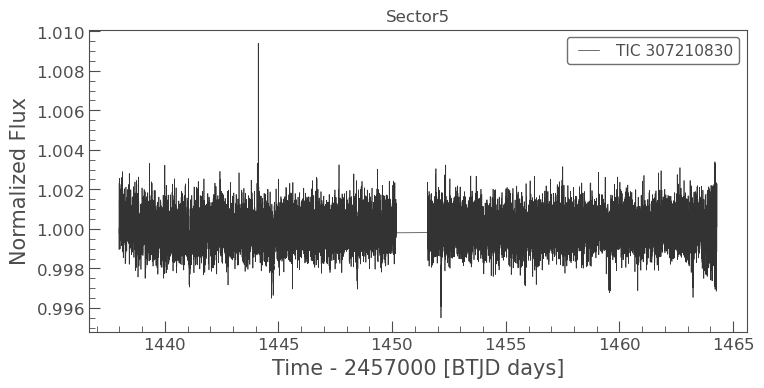

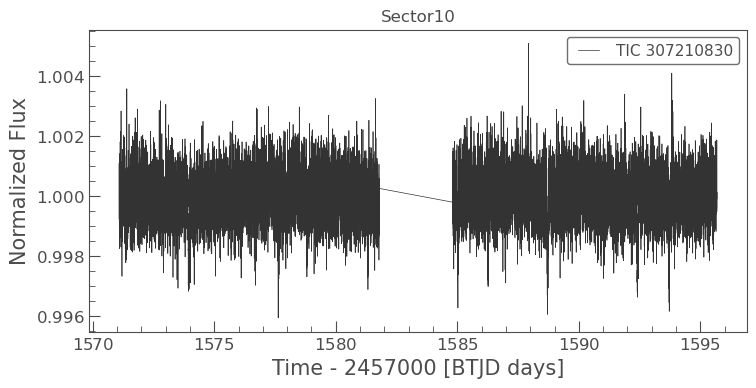

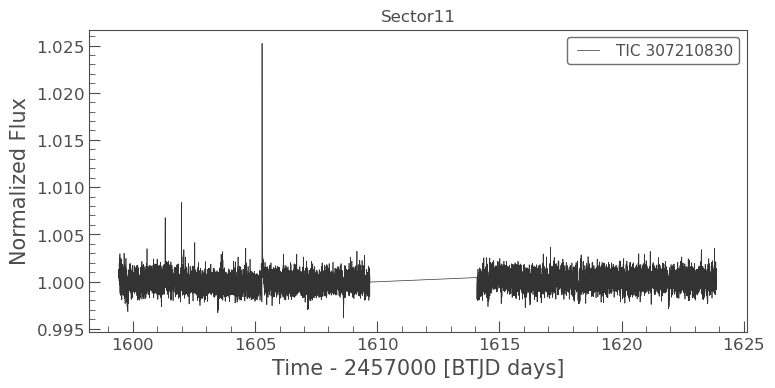

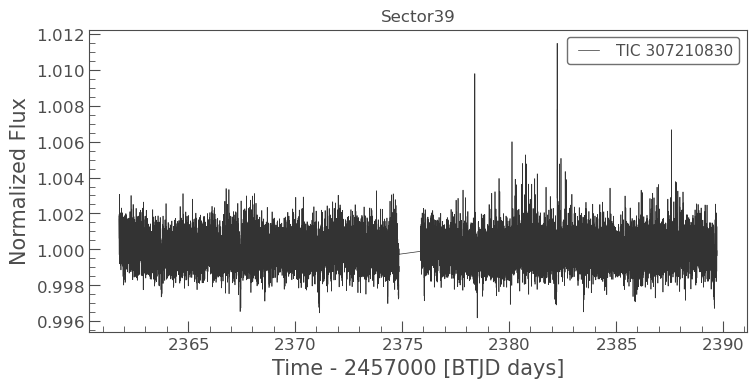

In [5]:
x = np.array([])
y = np.array([])
yerr = np.array([])

for lc in lcs:
    lc = lc.remove_nans().normalize()
    lc.plot(column="flux")
    plt.title(f"Sector{lc.hdu[0].header['SECTOR']}")
    
    xs = np.asarray(lc.time.value)
    ys = np.asarray(lc.flux.value - 1.0) * 1000.
    yerrs = np.asarray(lc.flux_err.value) * 1000.
    
    x = np.r_[x, xs]
    y = np.r_[y, ys]
    yerr = np.r_[yerr, yerrs]

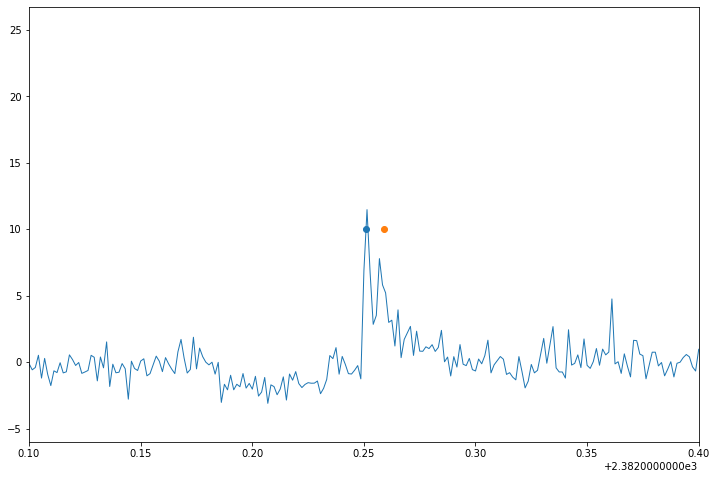

In [6]:
plt.figure(figsize=[12,8])
plt.plot(x, y, lw=1)
plt.xlim(2382.1, 2382.4)
plt.scatter(2382.251, 10)
plt.scatter(2382.259, 10)

In [7]:
# theres 1 at T = ~1445 sector 5

# ~1594 Sector 10

# 2382 sector 39


In [8]:

texp = 120./86400.
oversample = 7

In [9]:
tpeaks = np.array([1444.1122885,
                   1593.82437668,
                   1601.99062724, 1602.00066989, 1605.28537524, 1605.29722898,
                   2382.2508622, 2382.25794647])
fwhms = np.array([0.00398456,
                  0.0105785,
                  0.00278668, 0.01954066, 0.0022523, 0.0366627,
                  0.00251048, 0.00752962])
ampls = np.array([12.60124105,
                  5.16612309,
                  12.10499861,
                  2.22443822, 34.82844799, 3.40380817,
                  17.47512307,7.21241248])





In [10]:
# mask some data that is not near flares

mask = np.zeros_like(x, dtype=bool)

for i in tpeaks:
    mask[(x >=i-0.1) * (x < i+0.2)] = True
    
x = x[mask]
y = y[mask]
yerr = yerr[mask]

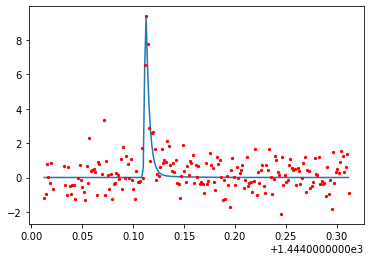

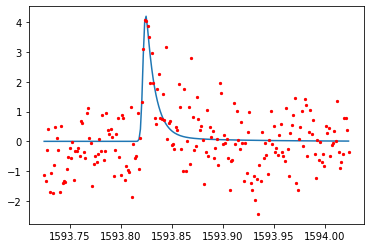

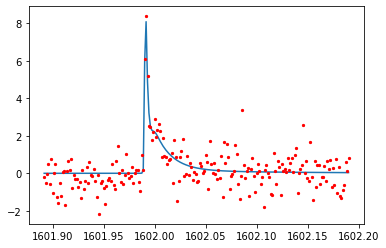

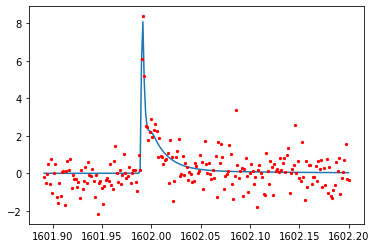

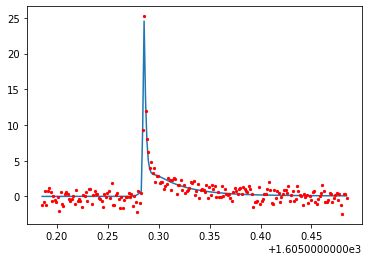

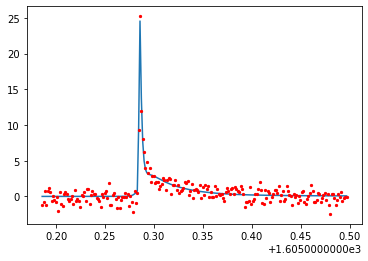

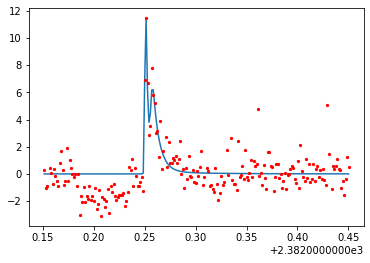

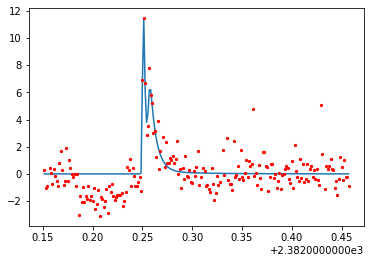

In [11]:
for i in range(len(tpeaks)):
    plt.figure()
    plt.plot(x[(x>=tpeaks[i]-0.2) * (x<tpeaks[i]+0.2)],
             multiflare(x[(x>=tpeaks[i]-0.2) * (x<tpeaks[i]+0.2)],
                        tpeaks, fwhms, ampls))

    plt.scatter(x[(x>=tpeaks[i]-0.2) * (x<tpeaks[i]+0.2)],
                y[(x>=tpeaks[i]-0.2) * (x<tpeaks[i]+0.2)],
                s=5, color="r", zorder=100)

# plt.xlim(1601.8, 1602.3)

# plt.ylim(-1, 10)

In [12]:
# split data into segments to compute seperate means for all groups

break_args = np.argwhere(np.diff(x) > 1).T[0]
n_segs = np.shape(break_args)[0] + 1

break_args = np.r_[-1, break_args, np.shape(x)[0]-1]
print(break_args)

[  -1  206  422  645  870 1085]


In [13]:
t = np.array([])
for i in range(n_segs):
    t = np.r_[t, np.arange(x[break_args[i]+1], x[break_args[i+1]], 0.0001)]
    print(x[break_args[i]+1], x[break_args[i+1]])

1444.0127163230723 1444.3113318330734
1593.7247110612143 1594.0233210841484
1601.8913410457174 1602.1996730500548
1605.1857683705828 1605.4968774976076
2382.151465035446 2382.457014443278


In [14]:
# create a pymc3 model

with pm.Model() as model:
    npeaks = np.shape(tpeaks)[0]
    
    # weird code to do the breakpoints so there are different mean values for all the flare segments
    mean_segs = pm.Normal("mean_segs", mu=-0.08, sd=0.4, testval=-0.08, shape=n_segs)
    mean = tt.zeros(np.shape(x)[0])
    for i in range(n_segs):
        mean = tt.set_subtensor(mean[break_args[i]+1: break_args[i+1]], mean_segs[i])
        
    logs2 = pm.Normal("logs2", mu=-1, sd=2.)
    
    tpeak = pm.Normal("tpeak", mu=tpeaks, sd=np.ones_like(tpeaks) * 0.005,
                      testval=tpeaks, shape=npeaks,
                      transform=pm.distributions.transforms.ordered)
    logFwhm = pm.Normal("logFwhm", mu=np.log(fwhms), sd=1, shape=npeaks, testval=np.log(fwhms))
    logAmpl = pm.Normal("logAmpl", mu=np.log(ampls), sd=2, shape=npeaks, testval=np.log(ampls))
    
    fwhm = pm.Deterministic("fwhm", tt.exp(logFwhm))
    ampl = pm.Deterministic("ampl", tt.exp(logAmpl))

    flare_lc = get_light_curve_120(x, tpeak, fwhm, ampl)
    
    pm.Deterministic("flare_lc", flare_lc)
    pm.Deterministic("mean", mean)
    
    pm.Normal("obs", mu=flare_lc + mean,
              sd=tt.sqrt(yerr**2 + tt.exp(2 * logs2)),
              observed=y)
    
    flare_lc_plot = get_light_curve_notexp(t, tpeak, fwhm, ampl)
    pm.Deterministic("flare_lc_plot", flare_lc_plot)



In [15]:
with model:
    map_soln = pmx.optimize(start=model.test_point, vars=[ampl, fwhm])
    map_soln = pmx.optimize(start=map_soln, vars=[tpeak, mean_segs])
    map_soln = pmx.optimize(start=map_soln, vars=[ampl, fwhm])
    map_soln = pmx.optimize(start=map_soln, vars=[tpeak, mean_segs])

optimizing logp for variables: [logFwhm, logAmpl]


message: Optimization terminated successfully.
logp: -1417.2767321083977 -> -1416.1944652734076
optimizing logp for variables: [mean_segs, tpeak]


message: Desired error not necessarily achieved due to precision loss.
logp: -1416.1944652734076 -> -1405.8807275159252
optimizing logp for variables: [logFwhm, logAmpl]


message: Optimization terminated successfully.
logp: -1405.8807275159252 -> -1404.6158976502998
optimizing logp for variables: [mean_segs, tpeak]


message: Desired error not necessarily achieved due to precision loss.
logp: -1404.6158976502998 -> -1404.1805138288657


In [16]:
map_soln

{'mean_segs': array([ 0.15686159, -0.16728546, -0.07084178, -0.10931429, -0.2503673 ]),
 'logs2': array(-1.),
 'tpeak_ordered__': array([ 1.44411225e+03,  5.00871624e+00,  2.09997699e+00, -4.55838987e+00,
         1.18913456e+00, -4.43047732e+00,  6.65538055e+00, -4.91730679e+00]),
 'logFwhm': array([-5.61291308, -4.37177297, -5.87317135, -4.17459843, -6.10540241,
        -3.29037588, -6.11945272, -4.65784658]),
 'logAmpl': array([2.56412846, 1.61237543, 2.55871265, 0.93848533, 3.55558477,
        1.24739789, 2.94891328, 1.95871286]),
 'tpeak': array([1444.1122549 , 1593.8246721 , 1601.99065409, 1602.001133  ,
        1605.28537067, 1605.29727947, 2382.25081437, 2382.25813319]),
 'fwhm': array([0.00365042, 0.01262883, 0.00281394, 0.01538137, 0.00223078,
        0.03723985, 0.00219966, 0.00948687]),
 'ampl': array([12.9893327 ,  5.01470919, 12.91917507,  2.55610684, 35.00828573,
         3.48127251, 19.08520216,  7.09019514]),
 'flare_lc': array([0.        , 0.        , 0.        , ...,

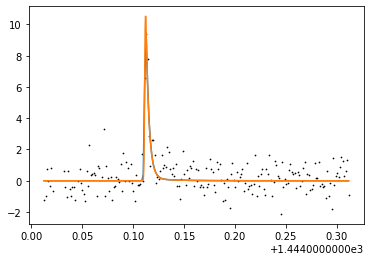

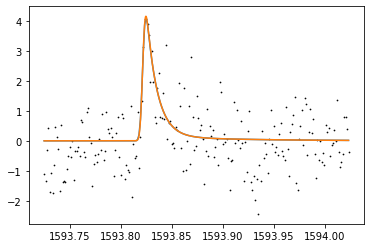

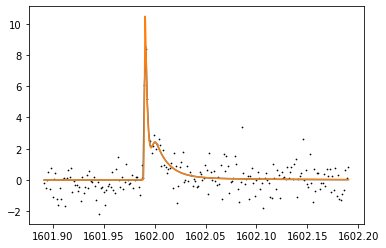

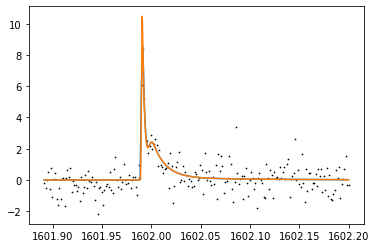

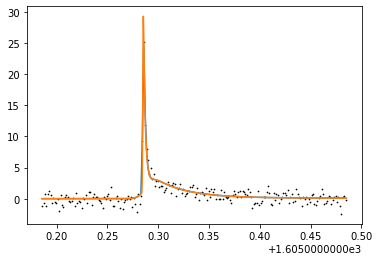

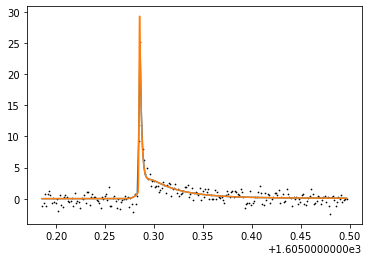

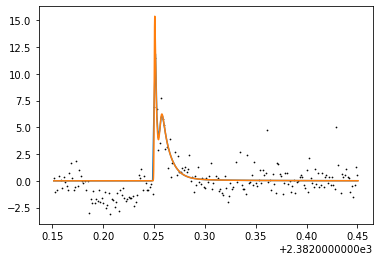

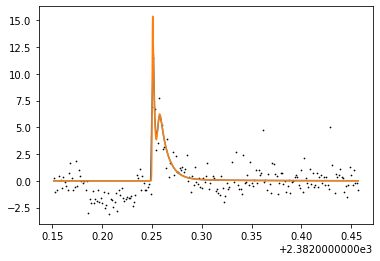

In [17]:
for i in range(len(tpeaks)):
    plt.figure()
    plt.plot(x[(x>=tpeaks[i]-0.2) * (x<tpeaks[i]+0.2)],
             map_soln["flare_lc"][(x>=tpeaks[i]-0.2) * (x<tpeaks[i]+0.2)])
    plt.plot(t[(t>=tpeaks[i]-0.2) * (t<tpeaks[i]+0.2)],
             map_soln["flare_lc_plot"][(t>=tpeaks[i]-2) * (t<tpeaks[i]+0.2)])
    
    plt.scatter(x[(x>=tpeaks[i]-0.2) * (x<tpeaks[i]+0.2)],
                y[(x>=tpeaks[i]-0.2) * (x<tpeaks[i]+0.2)],
                s=0.5, color="k")
    


In [18]:
with model:
    trace = pm.sample(
            tune=2500,
            draws=2000,
            cores=4,
            chains=4,
            target_accept=0.95,
            return_inferencedata=True,
#             random_seed=[261136679, 261136680, 8675309, 90210],
            init="adapt_full",
            start=map_soln,
        )

/tmp/ipykernel_28670/4126785317.py:2: DeprecationWarning: Call to deprecated Parameter start. (renamed to `initvals` in PyMC v4.0.0) -- Deprecated since v3.11.5.
  trace = pm.sample(
Auto-assigning NUTS sampler...
Initializing NUTS using adapt_full...
/home/tom/anaconda3/lib/python3.8/site-packages/pymc3/step_methods/hmc/quadpotential.py:510: UserWarning: QuadPotentialFullAdapt is an experimental feature
  warnings.warn("QuadPotentialFullAdapt is an experimental feature")
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [logAmpl, logFwhm, tpeak, logs2, mean_segs]


Sampling 4 chains for 2_500 tune and 2_000 draw iterations (10_000 + 8_000 draws total) took 1357 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 23 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


array([[<AxesSubplot:title={'center':'logs2'}>,
        <AxesSubplot:title={'center':'logs2'}>],
       [<AxesSubplot:title={'center':'tpeak'}>,
        <AxesSubplot:title={'center':'tpeak'}>],
       [<AxesSubplot:title={'center':'fwhm'}>,
        <AxesSubplot:title={'center':'fwhm'}>],
       [<AxesSubplot:title={'center':'ampl'}>,
        <AxesSubplot:title={'center':'ampl'}>],
       [<AxesSubplot:title={'center':'mean_segs'}>,
        <AxesSubplot:title={'center':'mean_segs'}>]], dtype=object)

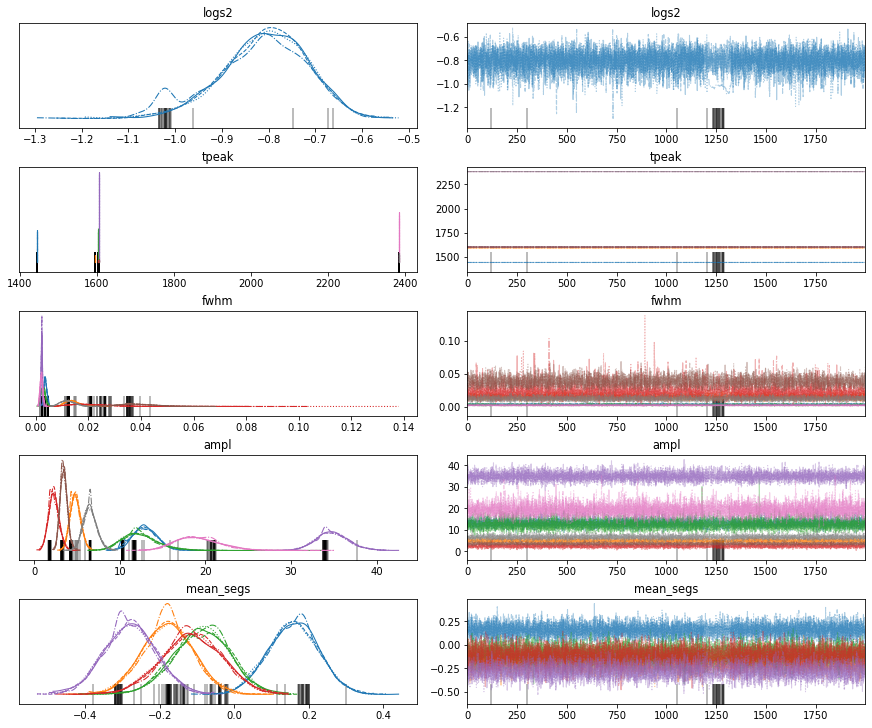

In [19]:
pm.plot_trace(trace, var_names=['logs2', 'tpeak', "fwhm", "ampl", "mean_segs"])

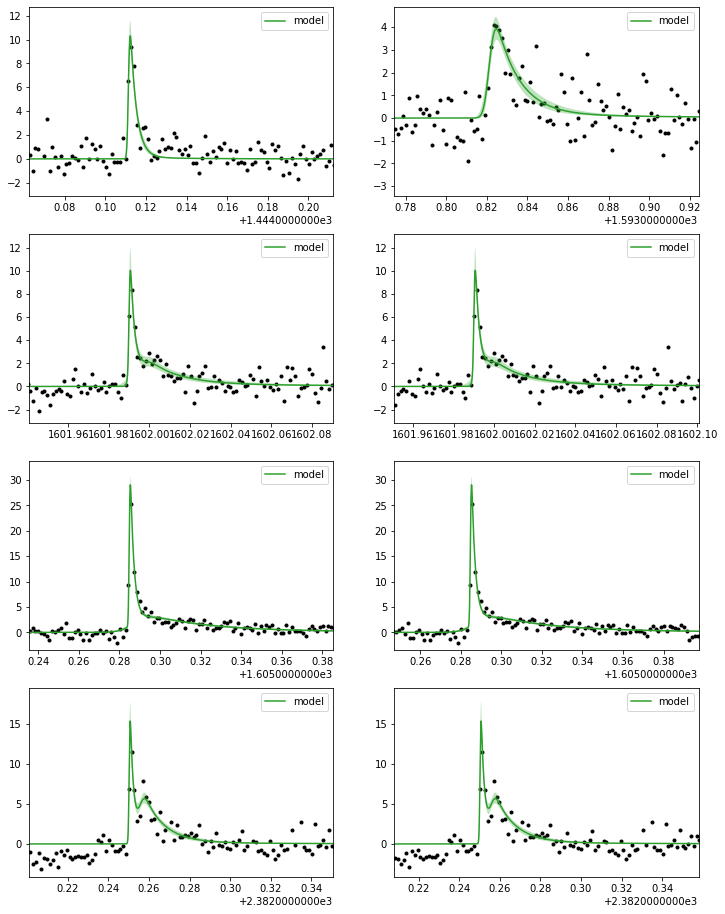

In [20]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

flct =  np.percentile(flat_samps['flare_lc_plot'], [15, 50, 85], axis=1)
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
    ttimemask = (t >= tpeaks[i]-0.2) * (t < tpeaks[i]+0.2)
    ax.plot(t[ttimemask], flct[1][ttimemask], color="C2", label="model")
    art = ax.fill_between(t[ttimemask], flct[0][ttimemask],
                          flct[2][ttimemask], color="C2", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    ax.set_ylim(np.min(y[timemask]) - 1, 1.1 * np.max(flct[2][ttimemask]))
    ax.legend()

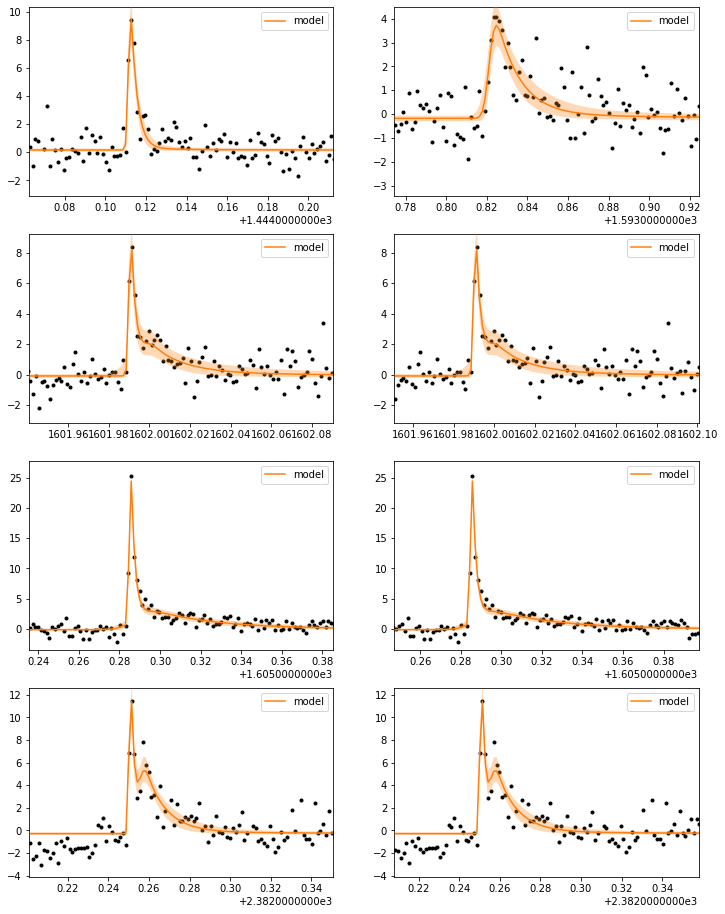

In [21]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

flc =  (np.percentile(flat_samps['flare_lc'], [5, 50, 95], axis=1) +
        np.percentile(flat_samps['mean'], [5, 50, 95], axis=1))
fig, axes = plt.subplots(ncols=2, nrows=np.ceil(npeaks/2).astype(int), figsize=[12,npeaks*2])
axes = axes.flatten()
for i in range(npeaks):
    timemask = (x >= tpeaks[i]-0.2) * (x < tpeaks[i]+0.2)
    ax = axes[i]
    ax.plot(x[timemask], y[timemask], '.k')
#     ax.plot(x[timemask], multiflare(x[timemask], tpeaks, fwhms, ampls), label='truth', zorder=1000)
    ax.plot(x[timemask], flc[1][timemask], color="C1", label="model")
    art = ax.fill_between(x[timemask], flc[0][timemask],
                          flc[2][timemask], color="C1", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(tpeaks[i]-0.05, tpeaks[i]+0.1)
    ax.set_ylim(np.min(y[timemask]) - 1, 1.1 * np.max(y[timemask]))
    ax.legend()

In [22]:
pm.summary(trace, var_names=["ampl", "fwhm", "tpeak", "logs2", "mean_segs"], round_to=6)

mean        sd       hdi_3%      hdi_97%  mcse_mean  \
ampl[0]         12.901519  1.491047    10.113414    15.539390   0.041963   
ampl[1]          4.804940  0.615311     3.692238     5.982223   0.007516   
ampl[2]         12.374655  2.137562     8.726374    16.586444   0.026129   
ampl[3]          2.278646  0.599426     1.150522     3.410047   0.008047   
ampl[4]         34.811415  1.880336    31.393363    38.525661   0.020896   
ampl[5]          3.445159  0.422949     2.657441     4.234453   0.006584   
ampl[6]         19.186093  2.666647    14.499120    24.164864   0.027690   
ampl[7]          6.513382  0.805962     4.974899     8.010032   0.008852   
fwhm[0]          0.003676  0.000588     0.002631     0.004768   0.000015   
fwhm[1]          0.014096  0.002903     0.009304     0.019982   0.000101   
fwhm[2]          0.002824  0.000845     0.001216     0.004332   0.000014   
fwhm[3]          0.021177  0.009212     0.007068     0.036602   0.000127   
fwhm[4]          0.002262  0.000218     0.001850     0.002661   0.000003   
fwhm[5]          0.038466  0.006789     0.025894     0.051067   0.000111   
fwhm[6]          0.002134  0.000527     0.001143     0.003094   0.000006   
fwhm[7]          0.012149  0.002721     0.007252     0.017250   0.000035   
tpeak[0]      1444.112258  0.000164  1444.111967  1444.112579   0.000004   
tpeak[1]      1593.824874  0.000691  1593.823615  1593.826146   0.000015   
tpeak[2]      1601.990641  0.000166  1601.990333  1601.990950   0.000002   
tpeak[3]      1602.000339  0.002452  1601.995219  1602.004724   0.000121   
tpeak[4]      1605.285377  0.000055  1605.285275  1605.285480   0.000001   
tpeak[5]      1605.297491  0.002136  1605.293615  1605.301656   0.000047   
tpeak[6]      2382.250792  0.000108  2382.250597  2382.250996   0.000001   
tpeak[7]      2382.258175  0.000643  2382.256917  2382.259351   0.000011   
logs2           -0.811769  0.093900    -0.989914    -0.636177   0.003522   
mean_segs[0]     0.158029  0.067357     0.026325     0.277416   0.000577   
mean_segs[1]    -0.179093  0.068369    -0.309107    -0.051447   0.000617   
mean_segs[2]    -0.087786  0.075580    -0.232729     0.048605   0.000804   
mean_segs[3]    -0.115189  0.082039    -0.273744     0.032170   0.000951   
mean_segs[4]    -0.280837  0.069358    -0.406686    -0.146698   0.000683   

               mcse_sd      ess_bulk     ess_tail     r_hat  
ampl[0]       0.029679   1171.336581   296.688039  1.004039  
ampl[1]       0.005322   6860.757185  5170.089791  1.001014  
ampl[2]       0.019781   7385.412942  5882.626116  1.003362  
ampl[3]       0.005690   5399.576648  4607.452884  1.001485  
ampl[4]       0.014928   8281.410371  5841.050786  1.000837  
ampl[5]       0.004769   4438.383094  4460.715600  1.000816  
ampl[6]       0.020345   9412.126904  5963.814207  1.001000  
ampl[7]       0.006261   8296.162029  4997.690365  1.002452  
fwhm[0]       0.000011   1693.357059  2494.691355  1.002840  
fwhm[1]       0.000080   1280.879431   320.282873  1.005188  
fwhm[2]       0.000010   3304.225696  3410.711820  1.002352  
fwhm[3]       0.000091   5474.645477  4907.086220  1.001248  
fwhm[4]       0.000002   4036.218446  4728.418045  1.001414  
fwhm[5]       0.000078   3784.470101  4777.955827  1.000588  
fwhm[6]       0.000004   6634.919591  5566.264292  1.001102  
fwhm[7]       0.000025   6055.576073  5840.335581  1.001842  
tpeak[0]      0.000003   1535.012213   430.603901  1.003184  
tpeak[1]      0.000011   2651.925552  2401.142769  1.002429  
tpeak[2]      0.000001   6812.524791  5024.351639  1.000584  
tpeak[3]      0.000086    437.249181   161.353857  1.011730  
tpeak[4]      0.000000   6130.339172  6973.820241  1.000386  
tpeak[5]      0.000033   2123.785147  2000.946146  1.002157  
tpeak[6]      0.000005   7669.287357  6632.105498  1.000554  
tpeak[7]      0.000008   4071.889006  3379.040127  1.001698  
logs2         0.002700    951.421040   262.923641  1.008248  
mean_segs[0]  0.000439  13710.297080  6255.850843  1

In [23]:
np.median(flat_samps["ampl"],axis=1)

array([12.85271397,  4.78068239, 12.15986587,  2.24944087, 34.7139988 ,
        3.42456326, 18.94951054,  6.48651253])

In [24]:
np.percentile(flat_samps["fwhm"],[15, 50, 85], axis=1, ) * 86400.

array([[ 265.57546037,  964.23479374,  168.47696625, 1112.94251155,
         175.8298058 , 2733.94948812,  137.54559601,  801.84618454],
       [ 313.1927706 , 1187.04542274,  238.86652955, 1690.74205578,
         195.20942303, 3266.06488922,  181.80190563, 1034.20854869],
       [ 371.78638144, 1476.96715851,  318.61691851, 2492.7677822 ,
         214.81608121, 3935.94607333,  231.57368774, 1302.89078457]])

In [25]:
np.median(flat_samps["tpeak"],axis=1)

array([1444.11225157, 1593.82482906, 1601.99063333, 1602.00051639,
       1605.28537523, 1605.29734704, 2382.25078563, 2382.25818838])

In [26]:
flat_samps["tpeak"].shape

(8, 8000)

(1601.9538407804946, 1602.1524510347544)

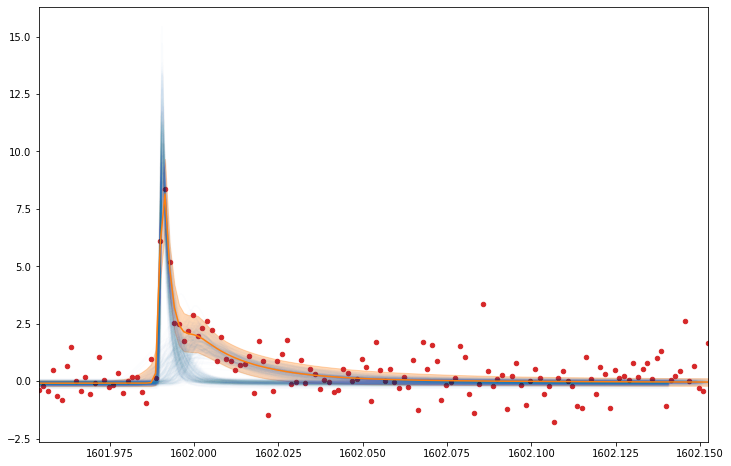

In [27]:
plt.figure(figsize=[12,8])



for j in [2,3]:
    for i in range(0,8000,40):
        tp = flat_samps["tpeak"][j,i].values
        fw = flat_samps["fwhm"][j,i].values
        am = flat_samps["ampl"][j,i].values
        m = flat_samps["mean"][:,i].values
        timemask = (x >= tp-0.05) * (x < tp+0.15)
        ttimemask = (t >= tp-0.05) * (t < tp+0.15)
        plt.plot(t[ttimemask], multiflare_notexp(t[ttimemask], [tp],
                               [fw],
                               [am]) + np.median(m[timemask]), color="C0", alpha=0.01)

flc =  (np.percentile(flat_samps['flare_lc'], [5, 50, 95], axis=1) +
        np.percentile(flat_samps['mean'], [5, 50, 95], axis=1))
plt.plot(x[timemask], flc[1][timemask], color="C1", label="model")
art = plt.fill_between(x[timemask], flc[0][timemask],
                      flc[2][timemask], color="C1", alpha=0.3,
                           )

plt.scatter(x[timemask], y[timemask], s=20, color="C3")
plt.xlim(x[timemask].min(), x[timemask].max())







7.961908182695108 +1.2547052656421798 -1.0718349841016988


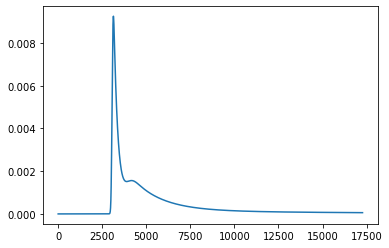

In [74]:
integral = [np.trapz(multiflare_notexp((t[ttimemask] - t[ttimemask][0]) * 86400,
                                       (flat_samps["tpeak"][:,i] - t[ttimemask][0]) * 86400,
                               flat_samps["fwhm"][:,i] * 86400,
                               flat_samps["ampl"][:,i])  / 1000,
                     x=(t[ttimemask] - t[ttimemask][0]) *  86400) for i in range(np.shape(flat_samps["tpeak"])[1])]
q = np.percentile(np.array(integral), [14.9,50,84.1])
print(f"{q[1]} +{q[2]-q[1]} -{q[1]-q[0]}")

plt.plot((t[ttimemask] - t[ttimemask][0]) * 86400, multiflare_notexp((t[ttimemask] - t[ttimemask][0]) * 86400,
                                       (flat_samps["tpeak"][:,i] - t[ttimemask][0]) * 86400,
                               flat_samps["fwhm"][:,i] * 86400,
                               flat_samps["ampl"][:,i])/1000)


(1605.2510457379506, 1605.449655581145)

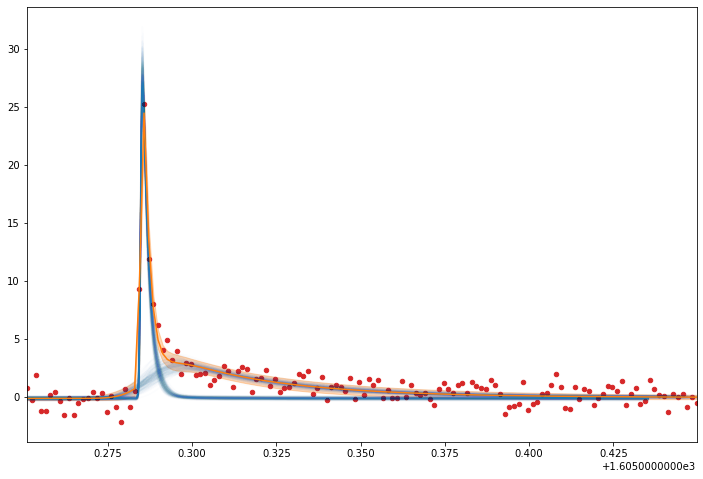

In [75]:
plt.figure(figsize=[12,8])



for j in [4,5]:
    for i in range(0,8000,40):
        tp = flat_samps["tpeak"][j,i].values
        fw = flat_samps["fwhm"][j,i].values
        am = flat_samps["ampl"][j,i].values
        m = flat_samps["mean"][:,i].values
        timemask = (x >= tp-0.05) * (x < tp+0.15)
        ttimemask = (t >= tp-0.05) * (t < tp+0.15)
        plt.plot(t[ttimemask], multiflare_notexp(t[ttimemask], [tp],
                               [fw],
                               [am]) + np.median(m[timemask]), color="C0", alpha=0.01)

flc =  (np.percentile(flat_samps['flare_lc'], [5, 50, 95], axis=1) +
        np.percentile(flat_samps['mean'], [5, 50, 95], axis=1))
plt.plot(x[timemask], flc[1][timemask], color="C1", label="model")
art = plt.fill_between(x[timemask], flc[0][timemask],
                      flc[2][timemask], color="C1", alpha=0.3,
                           )

plt.scatter(x[timemask], y[timemask], s=20, color="C3")
plt.xlim(x[timemask].min(), x[timemask].max())

19.10805637209514 +1.5970006726884627 -1.5795025924839479


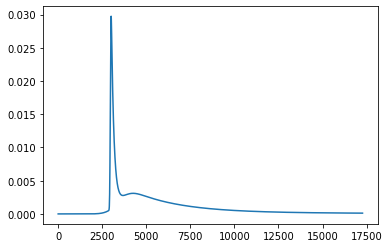

In [79]:
integral = [np.trapz(multiflare_notexp((t[ttimemask] - t[ttimemask][0]) * 86400,
                                       (flat_samps["tpeak"][:,i] - t[ttimemask][0]) * 86400,
                               flat_samps["fwhm"][:,i] * 86400,
                               flat_samps["ampl"][:,i])  / 1000,
                     x=(t[ttimemask] - t[ttimemask][0]) *  86400) for i in range(np.shape(flat_samps["tpeak"])[1])]
q = np.percentile(np.array(integral), [14.9,50,84.1])
print(f"{q[1]} +{q[2]-q[1]} -{q[1]-q[0]}")

plt.plot((t[ttimemask] - t[ttimemask][0]) * 86400, multiflare_notexp((t[ttimemask] - t[ttimemask][0]) * 86400,
                                       (flat_samps["tpeak"][:,i] - t[ttimemask][0]) * 86400,
                               flat_samps["fwhm"][:,0] * 86400,
                               flat_samps["ampl"][:,0])/1000)

(2382.2084083369, 2382.407015451732)

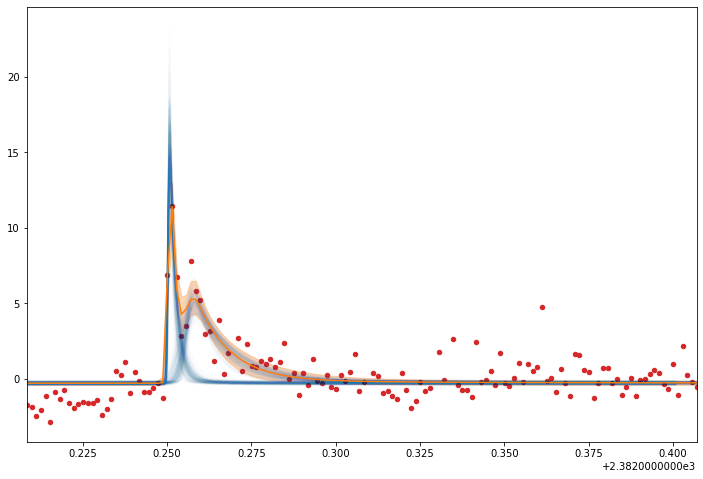

In [80]:
plt.figure(figsize=[12,8])



for j in [6,7]:
    for i in range(0,8000,40):
        tp = flat_samps["tpeak"][j,i].values
        fw = flat_samps["fwhm"][j,i].values
        am = flat_samps["ampl"][j,i].values
        m = flat_samps["mean"][:,i].values
        timemask = (x >= tp-0.05) * (x < tp+0.15)
        ttimemask = (t >= tp-0.05) * (t < tp+0.15)
        plt.plot(t[ttimemask], multiflare_notexp(t[ttimemask], [tp],
                               [fw],
                               [am]) + np.median(m[timemask]), color="C0", alpha=0.01)

flc =  (np.percentile(flat_samps['flare_lc'], [5, 50, 95], axis=1) +
        np.percentile(flat_samps['mean'], [5, 50, 95], axis=1))
plt.plot(x[timemask], flc[1][timemask], color="C1", label="model")
art = plt.fill_between(x[timemask], flc[0][timemask],
                      flc[2][timemask], color="C1", alpha=0.3,
                           )

plt.scatter(x[timemask], y[timemask], s=20, color="C3")
plt.xlim(x[timemask].min(), x[timemask].max())

7.289580834576078 +1.3675879874985757 -1.2593376053217478


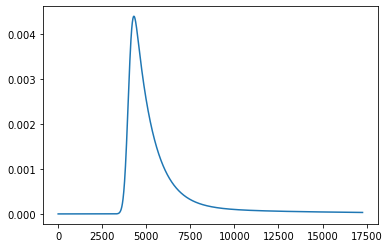

In [82]:
integral = [np.trapz(multiflare_notexp((t[ttimemask] - t[ttimemask][0]) * 86400,
                                       (flat_samps["tpeak"][[7],i] - t[ttimemask][0]) * 86400,
                               flat_samps["fwhm"][[7],i] * 86400,
                               flat_samps["ampl"][[7],i])  / 1000,
                     x=(t[ttimemask] - t[ttimemask][0]) *  86400) for i in range(np.shape(flat_samps["tpeak"])[1])]
q = np.percentile(np.array(integral), [14.9,50,84.1])
print(f"{q[1]} +{q[2]-q[1]} -{q[1]-q[0]}")

plt.plot((t[ttimemask] - t[ttimemask][0]) * 86400, multiflare_notexp((t[ttimemask] - t[ttimemask][0]) * 86400,
                                       (flat_samps["tpeak"][[7],i] - t[ttimemask][0]) * 86400,
                               flat_samps["fwhm"][[7],0] * 86400,
                               flat_samps["ampl"][[7],0])/1000)

(1444.0627170590355, 1444.261331095947)

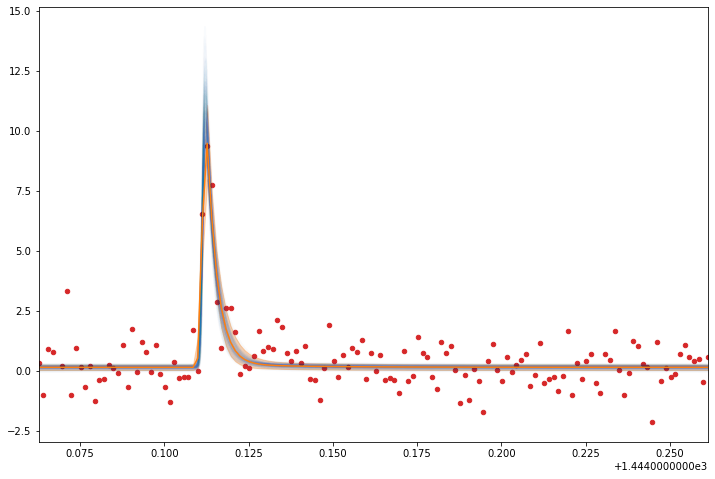

In [83]:
plt.figure(figsize=[12,8])



for j in [0]:
    for i in range(0,8000,40):
        tp = flat_samps["tpeak"][j,i].values
        fw = flat_samps["fwhm"][j,i].values
        am = flat_samps["ampl"][j,i].values
        m = flat_samps["mean"][:,i].values
        timemask = (x >= tp-0.05) * (x < tp+0.15)
        ttimemask = (t >= tp-0.05) * (t < tp+0.15)
        plt.plot(t[ttimemask], multiflare_notexp(t[ttimemask], [tp],
                               [fw],
                               [am]) + np.median(m[timemask]), color="C0", alpha=0.01)

flc =  (np.percentile(flat_samps['flare_lc'], [5, 50, 95], axis=1) +
        np.percentile(flat_samps['mean'], [5, 50, 95], axis=1))
plt.plot(x[timemask], flc[1][timemask], color="C1", label="model")
art = plt.fill_between(x[timemask], flc[0][timemask],
                      flc[2][timemask], color="C1", alpha=0.3,
                           )

plt.scatter(x[timemask], y[timemask], s=20, color="C3")
plt.xlim(x[timemask].min(), x[timemask].max())

4.1767894229610825 +0.44275601021759403 -0.41134190024604456


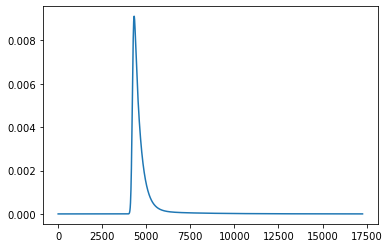

In [84]:
integral = [np.trapz(multiflare_notexp((t[ttimemask] - t[ttimemask][0]) * 86400,
                                       (flat_samps["tpeak"][:,i] - t[ttimemask][0]) * 86400,
                               flat_samps["fwhm"][:,i] * 86400,
                               flat_samps["ampl"][:,i])  / 1000,
                     x=(t[ttimemask] - t[ttimemask][0]) *  86400) for i in range(np.shape(flat_samps["tpeak"])[1])]
q = np.percentile(np.array(integral), [14.9,50,84.1])
print(f"{q[1]} +{q[2]-q[1]} -{q[1]-q[0]}")

plt.plot((t[ttimemask] - t[ttimemask][0]) * 86400, multiflare_notexp((t[ttimemask] - t[ttimemask][0]) * 86400,
                                       (flat_samps["tpeak"][:,i] - t[ttimemask][0]) * 86400,
                               flat_samps["fwhm"][:,0] * 86400,
                               flat_samps["ampl"][:,0])/1000)

(1593.7747108875724, 1593.9733212750193)

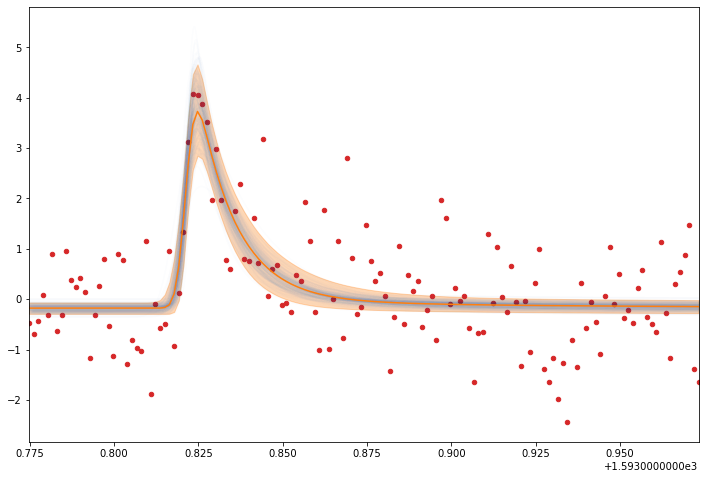

In [85]:
plt.figure(figsize=[12,8])



for j in [1]:
    for i in range(0,8000,40):
        tp = flat_samps["tpeak"][j,i].values
        fw = flat_samps["fwhm"][j,i].values
        am = flat_samps["ampl"][j,i].values
        m = flat_samps["mean"][:,i].values
        timemask = (x >= tp-0.05) * (x < tp+0.15)
        ttimemask = (t >= tp-0.05) * (t < tp+0.15)
        plt.plot(t[ttimemask], multiflare_notexp(t[ttimemask], [tp],
                               [fw],
                               [am]) + np.median(m[timemask]), color="C0", alpha=0.01)

flc =  (np.percentile(flat_samps['flare_lc'], [5, 50, 95], axis=1) +
        np.percentile(flat_samps['mean'], [5, 50, 95], axis=1))
plt.plot(x[timemask], flc[1][timemask], color="C1", label="model")
art = plt.fill_between(x[timemask], flc[0][timemask],
                      flc[2][timemask], color="C1", alpha=0.3,
                           )

plt.scatter(x[timemask], y[timemask], s=20, color="C3")
plt.xlim(x[timemask].min(), x[timemask].max())

6.475883140425175 +0.8982597090193778 -0.8485483450501814


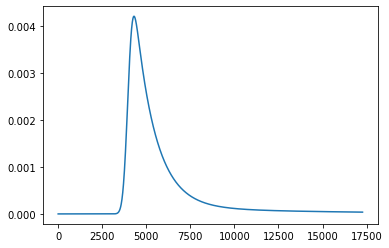

In [86]:
integral = [np.trapz(multiflare_notexp((t[ttimemask] - t[ttimemask][0]) * 86400,
                                       (flat_samps["tpeak"][:,i] - t[ttimemask][0]) * 86400,
                               flat_samps["fwhm"][:,i] * 86400,
                               flat_samps["ampl"][:,i])  / 1000,
                     x=(t[ttimemask] - t[ttimemask][0]) *  86400) for i in range(np.shape(flat_samps["tpeak"])[1])]
q = np.percentile(np.array(integral), [14.9,50,84.1])
print(f"{q[1]} +{q[2]-q[1]} -{q[1]-q[0]}")

plt.plot((t[ttimemask] - t[ttimemask][0]) * 86400, multiflare_notexp((t[ttimemask] - t[ttimemask][0]) * 86400,
                                       (flat_samps["tpeak"][:,i] - t[ttimemask][0]) * 86400,
                               flat_samps["fwhm"][:,0] * 86400,
                               flat_samps["ampl"][:,0])/1000)

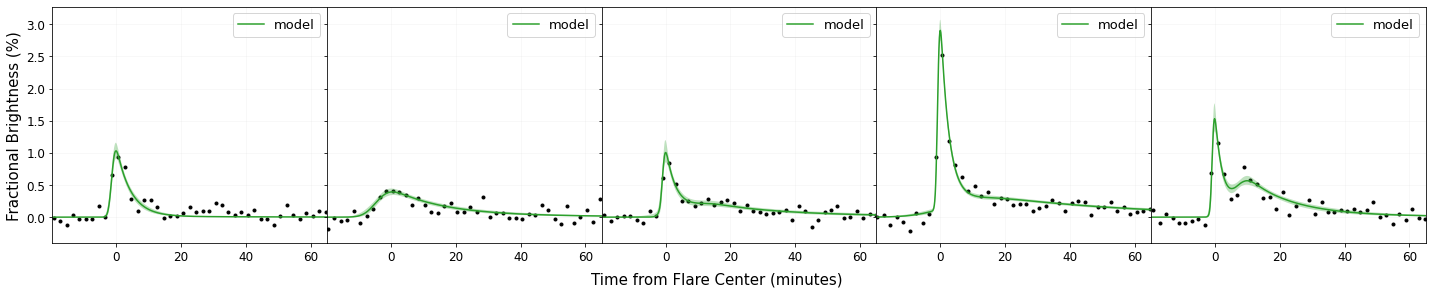

In [96]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

flct =  np.percentile(flat_samps['flare_lc_plot'], [15, 50, 85], axis=1)
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=[20,4], sharey=True)

axes = axes.flatten()
for i,axidx in enumerate([0, 1, 2, 4, 6]):
    timemask = (x >= tpeaks[axidx]-0.2) * (x < tpeaks[axidx]+0.2)
    ax = axes[i]
    ax.plot((x[timemask] -tpeaks[axidx]) * 1440, y[timemask] / 10, '.k')
    ttimemask = (t >= tpeaks[axidx]-0.2) * (t < tpeaks[axidx]+0.2)
    ax.plot((t[ttimemask] - tpeaks[axidx]) * 1440, flct[1][ttimemask] / 10, color="C2", label="model")
    art = ax.fill_between((t[ttimemask] - tpeaks[axidx]) * 1440, flct[0][ttimemask]/10,
                          flct[2][ttimemask]/10, color="C2", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(-0.33 * 60, +1. * 65)
    ax.set_ylim((np.min(y[timemask]) - 1)/10, (1.85 * np.max(flct[2][ttimemask]))/10)
    ax.grid(":", alpha=0.1)
    ax.legend(fontsize=13)
    ax.tick_params(axis='both', which='major', labelsize=12)

axes[0].set_ylabel("Fractional Brightness (%)", fontsize=15)


fig.text(0.5, 0.00, 'Time from Flare Center (minutes)', ha='center', fontsize=15)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0, bottom=0.14)


fig.savefig("l98-flares.png")

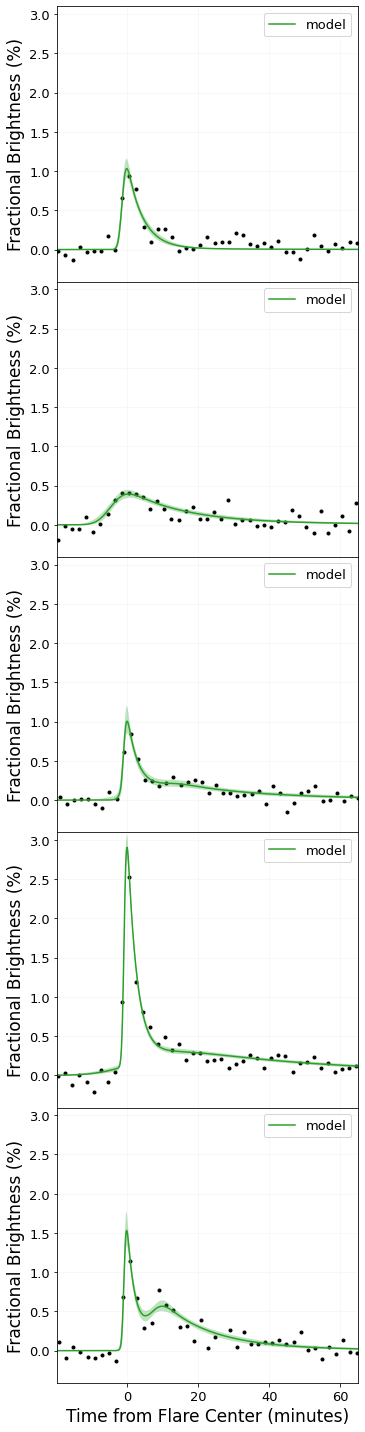

In [111]:
flat_samps = trace.posterior.stack(sample=("chain", "draw"))

flct =  np.percentile(flat_samps['flare_lc_plot'], [15, 50, 85], axis=1)
fig, axes = plt.subplots(ncols=1, nrows=5, figsize=[5,20], sharey=True)

axes = axes.flatten()
for i,axidx in enumerate([0, 1, 2, 4, 6]):
    timemask = (x >= tpeaks[axidx]-0.2) * (x < tpeaks[axidx]+0.2)
    ax = axes[i]
    ax.plot((x[timemask] -tpeaks[axidx]) * 1440, y[timemask] / 10, '.k')
    ttimemask = (t >= tpeaks[axidx]-0.2) * (t < tpeaks[axidx]+0.2)
    ax.plot((t[ttimemask] - tpeaks[axidx]) * 1440, flct[1][ttimemask] / 10, color="C2", label="model")
    art = ax.fill_between((t[ttimemask] - tpeaks[axidx]) * 1440, flct[0][ttimemask]/10,
                          flct[2][ttimemask]/10, color="C2", alpha=0.3,
                               zorder=1000)
    art.set_edgecolor("none")
    ax.set_xlim(-0.33 * 60, +1. * 65)
    ax.set_ylim((np.min(y[timemask]) - 1)/10, (1.75 * np.max(flct[2][ttimemask]))/10)
    ax.grid(":", alpha=0.1)
    ax.legend(fontsize=13)
    ax.tick_params(axis='both', which='major', labelsize=13)
    ax.set_ylabel("Fractional Brightness (%)", fontsize=17)
axes[-1].set_xlabel("Time from Flare Center (minutes)", fontsize=17)

# fig.text(0.5, 0.00, 'Time from Flare Center (minutes)', ha='center', fontsize=15)

fig.tight_layout()
fig.subplots_adjust(wspace=0, hspace=0)


fig.savefig("l98-flares.png",dpi=200)

SearchResult containing 15 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 02 2018   SPOC     120   307210830      0.0
  1 TESS Sector 05 2018   SPOC     120   307210830      0.0
  2 TESS Sector 08 2019   SPOC     120   307210830      0.0
  3 TESS Sector 09 2019   SPOC     120   307210830      0.0
  4 TESS Sector 10 2019   SPOC     120   307210830      0.0
  5 TESS Sector 11 2019   SPOC     120   307210830      0.0
  6 TESS Sector 12 2019   SPOC     120   307210830      0.0
  7 TESS Sector 28 2020   SPOC     120   307210830      0.0
  8 TESS Sector 29 2020   SPOC     120   307210830      0.0
  9 TESS Sector 32 2020   SPOC     120   307210830      0.0
 10 TESS Sector 35 2021   SPOC     120   307210830      0.0
 11 TESS Sector 36 2021   SPOC     120   307210830      0.0
 12 TESS Sector 37 2021   SPOC     120   307210830      0.0
 13 TESS Sector 38 2021   SPOC     120   307210830      0.0
 14 TESS Sector 39 2021   SPOC     120   307210830      0.0